# Build a SVM classification algo to drive Swarms based on ML strategies

## Objectives
1 ) Create an unsupervised ML ( machine learning) algorithm to predict the different market regimes.

2) Plot these regimes to visualize them.

3)Train a Support Vector Classifier algorithm with the regime as one of the features.

4)Use this Support Vector Classifier algorithm to predict the current day’s trend at the Opening of the market.

5)Visualize the performance of this strategy on the test data.¶

In [26]:
# run this notebook in http://colab.research.google.com

#### if you run from Colab you will need to ! pip the following:

-! pip install jhtalib  # some prefab technical indicators calculation for feature engineering

-! pip install pyti

-! pip install quandl # for daily futures data

-! pip install bt # for portfolio construction and return calculation and equity data! pip install ffn

-! pip install tiingo # other data sources
-! pip install alpha_vantage

In [27]:
# How to rename pandas Columns

In [28]:
import numpy as np
import pandas as pd

import scipy
import statsmodels.api as sm


from sklearn import mixture as mix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


import bt
import ffn
import jhtalib as jhta
import datetime 

# import matplotlib as plt 
import seaborn as sns
sns.set()


import datetime
import matplotlib.pyplot as plt



#AlphaVantage Key insert quandl and tiingo also
AlphaVantage_key = 'AVC65FM7A32OFUBP'

from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries


ti = TechIndicators(key=AlphaVantage_key, output_format='pandas')
ts = TimeSeries(key=AlphaVantage_key, output_format='pandas', indexing_type='date')




In [29]:
#If want Futures data call Quandl


# # Dates
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime(2019, 1, 27)

import quandl
quandl_key = '3bQZxu98ay2a-UGyRTdx'
# quandl.get("CHRIS/CME_HG2"), CHRIS/CME_ES1, "CHRIS/SHFE_AL1",  ("CHRIS/EUREX_FGBS2"), CHRIS/CME_US2"),ASX_YT2
# CHRIS/EUREX_FOAT2", CME_EC1, EUREX_FESX2, EUREX_FDAX1, CME_CD1, CME_JY1, CME_GC1, CME_SI1, CME_MP1, CME_RU1, CME_AD1
# CME_TY1, CME_W1, CME_C1, CME_S1, CME_ED15, LIFFE_I1, CME_CL1, ICE_G2,CME_NG1, CME_RB1
#insert the required product ticker https://www.quandl.com/data/CHRIS-Wiki-Continuous-Futures
df = quandl.get("CHRIS/CME_ES1", api_key= quandl_key,
                start_date=start, end_date=end)


data_ts = df[['Open', 'High', 'Low', 'Settle']]
df = data_ts[['Open', 'High', 'Low', 'Settle']]
df.index = pd.to_datetime(df.index)
df.columns = ['Open', 'High', 'Low', 'Close']
df.index.rename('date', inplace=True)

df = df.dropna()
# df = df.
df = df.ffill()

df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

# Potential Values to include in strategy context

In [30]:
'''
want to make these a part of the strategy context.
t = 0.2
n = 7 # look back days for indicators
speed = 8.0
n_components=7
split2 = int(0.45*len(Regimes)) # alter the training period

'''

'\nwant to make these a part of the strategy context.\nt = 0.2\nn = 7 # look back days for indicators\nspeed = 8.0\nn_components=7\nsplit2 = int(0.45*len(Regimes)) # alter the training period\n\n'

# Call Data and rename the required Columns

In [31]:
# #If we want Equity or ETF data call Alpha Vantage



# # Get data
# product_name ='xlv'



# data_ts, meta_data_ts = ts.get_daily_adjusted(product_name,  outputsize='full')
           

# data_ts = pd.DataFrame(data_ts,)
# data_ts.index = pd.to_datetime(data_ts.index)


# #rename the columns as desired

# data_ts.columns =['Open', 'High', 'Low', 'Close', 'Adjusted Close',
#                  'Volume', 'Dividend', 'Split Coeff']



# df = data_ts[['Open', 'High', 'Low', 'Adjusted Close']]


# df = data_ts[['Open', 'High', 'Low', 'Close']]
# df.index = pd.to_datetime(df.index)
# df.head()

In [32]:
# bokeh basics
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
from bokeh.plotting import figure 
from bokeh.models import DatetimeTickFormatter
from bokeh.plotting import figure

output_notebook()

# Create a blank figure with labels
p = figure(plot_width = 600, plot_height = 600, 
           title = 'Example Glyphs',
           x_axis_label = 'date', y_axis_label = 'Price in $s', 
           x_axis_location='above',y_axis_location='right',# set axis location heres
           x_axis_type='datetime',
          background_fill_color='black', #set background color and 
          border_fill_color='orange',) 

# p.xaxis.formatter=DatetimeTickFormatter(
# #         hours=["%d %B %Y"],
# #         days=["%d %B %Y"],
#         months=["%d %B %Y"],
# #         years=["%d %B %Y"],
#     )
p.xaxis.major_label_orientation = 2/4


p.line(df.index, df['Close'],line_color='yellow', line_width=2,)
show(p)



Loading BokehJS ...

# Objectives


######  1 ) Create an unsupervised ML ( machine learning) algorithm to predict the regimes.
###### 2) Plot these regimes to visualize them.
######  3)Train a Support Vector Classifier algorithm with the regime as one of the features.
######  4)Use this Support Vector Classifier algorithm to predict the current day’s trend at the Opening of the market.
######  5)Visualize the performance of this strategy on the test data.


In [33]:
#split data into train, test and validate


t = 0.2
split = int(t*len(df))

split

715

# Define Features required for Feature Engineering stage

In [34]:
# Begin the feature engineering by shifting the values so informantion
# available today can be used to infer tomorrow values.

n = 13 # look back days for indicators
speed = 2.0

df['High feature'] = df['High'].shift(1)
df['Low feature'] = df['Low'].shift(1)
df['Close feature'] = df['Close'].shift(1)
df['RSI'] = pd.DataFrame(jhta.RSI(df, n=n, price='Close'),index=df.index)
df['SMA'] = df['Close'].rolling(window=n).mean()
df['Corr'] = df['SMA'].rolling(window=n).corr(df['Close'])
df['SAR'] = pd.DataFrame(jhta.SAR(df,af_step=0.21, af_max=0.015),index=df.index)
df['SAR2'] = pd.DataFrame(jhta.SAR(df,af_step=0.21*speed, af_max=0.015*speed),index=df.index)

df['ATR'] = pd.DataFrame(jhta.ATR(df,n=n),index=df.index)
df['Return'] = np.log(df['Open']/df['Open'].shift(1))
# df['Return'] = np.log(df['Close']/df['Close'].shift(1))
# df['Return'] = np.log(df['Close']/df['Close'].shift(1))
df['Monthly MA'] = df['Close'].resample('BM').mean().rolling(3).mean()
df['Monthly MA'] = df['Monthly MA'].fillna(method='ffill')

# df.pop('Weekly MA')

df = df.dropna()


# df['Close'].asfreq('D', method='ffill').tail()
# df['Close'].asfreq('w', method='ffill').tail()
# df['Close'].asfreq('BM', method='ffill').tail()

# Plot Defined features from Feature Engineering Phase for Sanity Check

In [35]:

# output_notebook()

# # Create a blank figure with labels
# p = figure(plot_width = 600, plot_height = 400, 
#            title = 'Example Glyphs',
#            x_axis_label = 'date', y_axis_label = 'Price in $s', 
#            x_axis_location='above',y_axis_location='right',# set axis location heres
#            x_axis_type='datetime',
#           background_fill_color='black', #set background color and 
#           border_fill_color='orange',) 

# # p.xaxis.formatter=DatetimeTickFormatter(
# # #         hours=["%d %B %Y"],
# # #         days=["%d %B %Y"],
# #         months=["%d %B %Y"],
# # #         years=["%d %B %Y"],
# #     )
# p.xaxis.major_label_orientation = 2/4


# p.line(df.index, df['Close'].loc['2016':'2018'],line_color='orange', line_width=2,)
# p.line(df.index, df['SAR'].loc['2016':'2018'],line_color='green', line_width=2,)
# p.line(df.index, df['SAR2'].loc['2016':'2018'],line_color='blue', line_width=2,)
# p.line(df.index, df['Monthly MA'].loc['2016':'2018'],line_color='cyan', line_width=2,)
# p.line(df.index, df['SAR3'].loc['2018'],line_color='blue', line_width=2,)
# show(p)

# Error checking and cleaning data for learning

In [36]:
np.any(np.isnan(df))

False

In [37]:


np.all(np.isfinite(df))

True

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3517 entries, 2005-03-31 to 2018-12-28
Data columns (total 15 columns):
Open             3517 non-null float64
High             3517 non-null float64
Low              3517 non-null float64
Close            3517 non-null float64
High feature     3517 non-null float64
Low feature      3517 non-null float64
Close feature    3517 non-null float64
RSI              3517 non-null float64
SMA              3517 non-null float64
Corr             3517 non-null float64
SAR              3517 non-null float64
SAR2             3517 non-null float64
ATR              3517 non-null float64
Return           3517 non-null float64
Monthly MA       3517 non-null float64
dtypes: float64(15)
memory usage: 439.6 KB


In [39]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
df = clean_dataset(df)

In [40]:
ss = StandardScaler()

unsup = mix.GaussianMixture(n_components=7, covariance_type='spherical', 
                            n_init=100, init_params='kmeans',
                            random_state=43,)

unsup.fit(np.reshape(ss.fit_transform(df[:split]),(-1, df.shape[1])))
regime = unsup.predict(np.reshape(ss.fit_transform(df[split:]),(-1, df.shape[1])))


In [41]:
regime

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [42]:
Regimes = pd.DataFrame(regime, columns=['Regime'], index=df[split:].index)\
.join(df[split:], how='inner')\
     .assign(market_cu_return=df[split:]\
             .Return.cumsum())\
             .reset_index(drop=False)\
             .rename(columns={'index':'Date'})

# Plot the Identified Regimes from the SVM

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


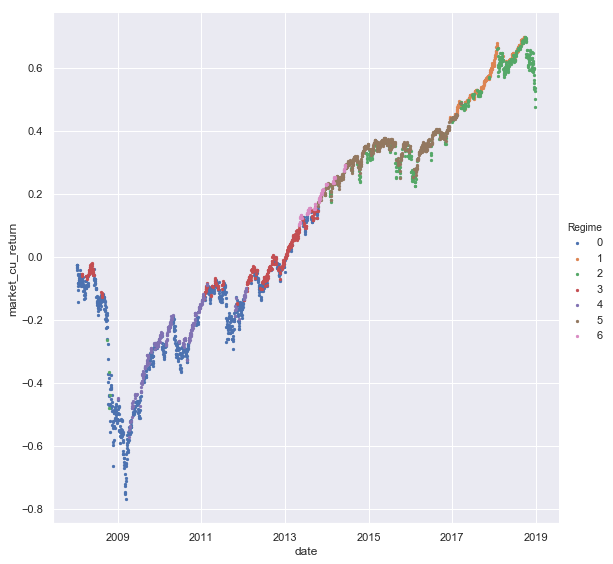

In [43]:
order = [0,1,2,3,4,5,6]
fig = sns.FacetGrid(data=Regimes,hue='Regime', hue_order=order, aspect =1,size=8)
fig.map(plt.scatter, 'date', 'market_cu_return', s=5).add_legend()

# for i in order:
#     print('Mean for regime %i:'%i, unsup.means_[i][0])
#     print('Co-Variance for regime %i: '%i,(unsup.covariances_[i]))
plt.show()

# Apply the StandardScaler to rescale the data for learning

In [44]:
ss1 = StandardScaler()
columns = Regimes.columns.drop(['Regime', 'date'])
Regimes[columns] = ss1.fit_transform(Regimes[columns])
Regimes['Signal'] = 0
Regimes.loc[Regimes['Return']>0, 'Signal']= 1.00
Regimes.loc[Regimes['Return']<0, 'Signal']= -1.00

# Calibrate the support vector machine for classification

In [45]:
cls = SVC(C=3.0, cache_size=100, class_weight=None, coef0=3.0,
          decision_function_shape=None, degree=4, 
          gamma='auto', kernel='rbf', max_iter=-1, probability=False,
          random_state=None, shrinking=True, 
          tol=0.001, verbose=False,  )

### X is the input or predictors, y is the signal we want to predict (-1, bearish or 1, bullish)

In [46]:
split2 = int(0.7*len(Regimes)) # alter the training period

X = Regimes.drop(['Signal','Return', 'market_cu_return', 'date'], axis=1)
y = Regimes['Signal']

cls.fit(X[:split2], y[:split2])

SVC(C=3.0, cache_size=100, class_weight=None, coef0=3.0,
  decision_function_shape=None, degree=4, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
p_data = len(X)-split2

df['Pred_Signal']=0
df.iloc[-p_data: ,df.columns.get_loc('Pred_Signal')]=cls.predict(X[split2:])

# print(df['Pred_Signal'][-p_data:])
df['str_ret'] = df['Pred_Signal']*df['Return'].shift(-1)

In [48]:
# df.iloc[-p_data: ,df.columns.get_loc('Pred_Signal')]['2018'].tail(150).plot()
# plt.show()

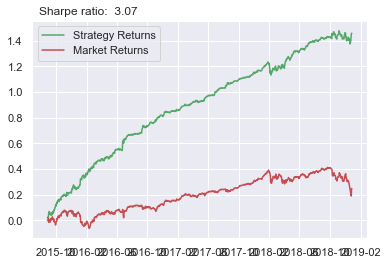

In [49]:
df['strategy_cu_return'] = 0.
df['market_cu_return'] = 0.

df.iloc[-p_data:, df.columns.get_loc('strategy_cu_return')]\
    =np.nancumsum(df['str_ret'][-p_data:])
df.iloc[-p_data:,df.columns.get_loc('market_cu_return')]\
    =np.nancumsum(df['Return'][-p_data:])
Sharpe = (df['strategy_cu_return'][-1]-df['market_cu_return'][-1])\
    /np.nanstd(df['strategy_cu_return'][-p_data:])

p.xaxis.major_label_orientation = 2/4
plt.plot(df['strategy_cu_return'][-p_data:], color='g', label='Strategy Returns', )
plt.plot(df['market_cu_return'][-p_data:], color='r', label='Market Returns')
plt.figtext(0.14, .9, s='Sharpe ratio: % .2f'%Sharpe)

# plt.Axes(xscale=)
plt.legend(loc= 'best')


plt.show()


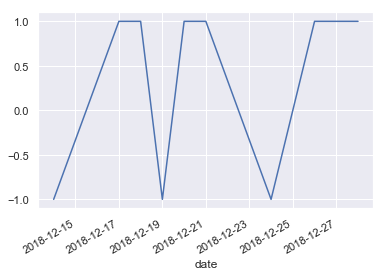

In [50]:
df.iloc[-p_data: ,df.columns.get_loc('Pred_Signal')]['2018'].tail(10).plot()
plt.show()